In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec_J1226.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec_J1226.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike_J1226.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em_J1226.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order_J1226.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud_J1226.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
prefix = './retrieval_outputs/fiducial_J_B_ret_8/test_'
#w_set = 'K2166'
w_set = 'J1226'
n_params = 29

res = read_results(prefix=prefix, n_params=n_params)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, _, bestfit_params = res
del res

  analysing data from ./retrieval_outputs/fiducial_J_B_ret_8/test_.txt
(2463, 29)


In [3]:
pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_{w_set}.pkl')

# Decrease the rotational broadening
params = bestfit_params['params'].copy()
params_hole = bestfit_params['params'].copy()
params_hole['vsini'] = 3
pRT_atm.params = params_hole

# Compute a new model spectrum
m_spec_hole = pRT_atm(Chem.mass_fractions, PT.temperature, params_hole, get_contr=False, get_full_spectrum=False)

In [17]:
# Create a synthetic spectrum
params_1 = bestfit_params['params'].copy()
pRT_atm.params = params_1
m_spec_1 = pRT_atm(Chem.mass_fractions, PT.temperature, params_1)

params_2 = bestfit_params['params'].copy()
params_2['rv'] -= 5
params_2['vsini'] = 2
pRT_atm.params = params_2
m_spec_2 = pRT_atm(Chem.mass_fractions, PT.temperature, params_2)

f1, f2 = 0.95, 0.05
#f1, f2 = 1, 0
synth_flux = m_spec_1.flux*f1 + m_spec_2.flux*f2

for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        synth_flux[i,j] += np.random.normal(
            np.zeros_like(synth_flux[i,j]), d_spec.err[i,j]
            )

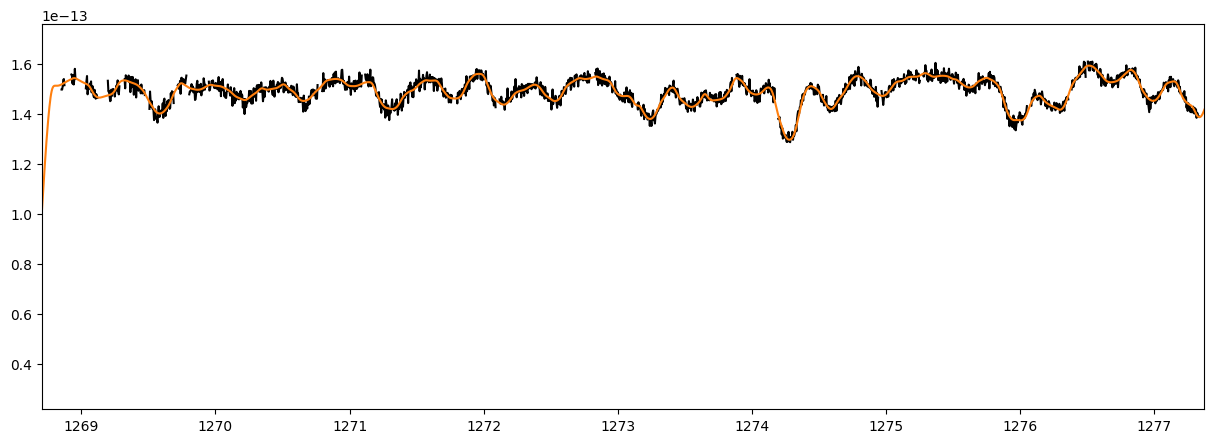

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        ax.plot(d_spec.wave[i,j], synth_flux[i,j], c='k')
        ax.plot(d_spec.wave[i,j], m_spec_1.flux[i,j], c='C1')

ax.set(
    xlim=(d_spec.wave[-2,0].min(), d_spec.wave[-2,0].max()), 
    ylim=(np.nanmin(d_spec.flux), np.nanmax(d_spec.flux)*1.2)
    )
plt.show()

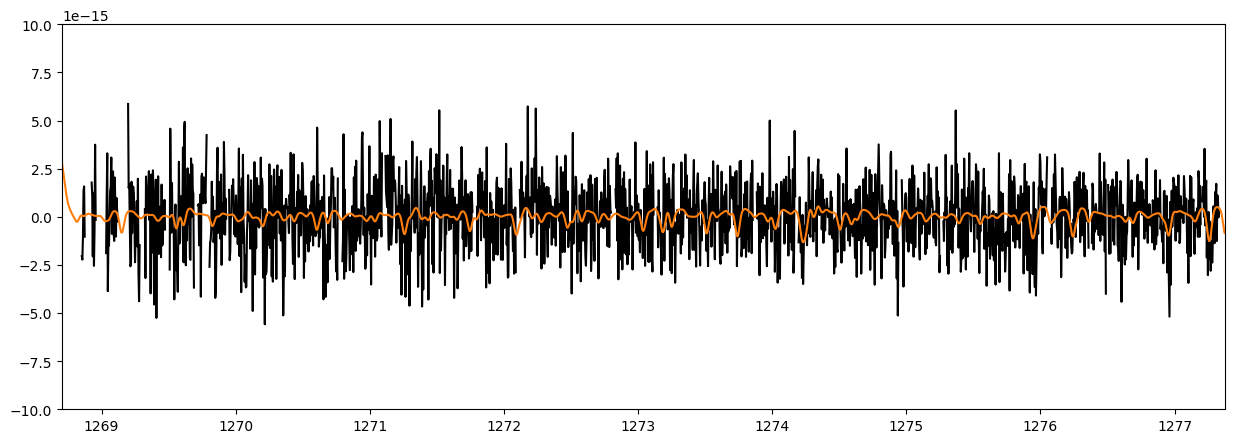

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        ax.plot(d_spec.wave[i,j], synth_flux[i,j]-m_spec_1.flux[i,j], c='k')
        ax.plot(d_spec.wave[i,j], (m_spec_2.flux[i,j]-m_spec_1.flux[i,j])*f2, c='C1')

ax.set(
    xlim=(d_spec.wave[-2,0].min(), d_spec.wave[-2,0].max()), 
    ylim=(-1e-14,1e-14)
    )
plt.show()

In [20]:
from tqdm import tqdm

res_flux = (synth_flux - m_spec_1.flux)
rv = np.arange(-100,100+1e-6,1)

CCF = np.ones((len(rv), d_spec.n_orders, d_spec.n_dets)) * np.nan

for i, rv_i in enumerate(tqdm(rv)):
    
    params_2['rv'] = params_1['rv'] + rv_i
    pRT_atm.params = params_2

    # Compute a new model spectrum
    m_spec_2 = pRT_atm(Chem.mass_fractions, PT.temperature, params_2)

    flux_i = m_spec_2.flux - m_spec_1.flux

    CCF[i,:,:] = np.nansum(
        res_flux * flux_i/d_spec.err**2, axis=-1
        )

100%|██████████| 201/201 [03:13<00:00,  1.04it/s]


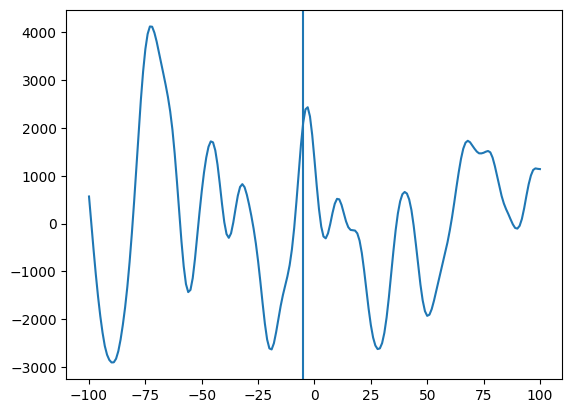

In [16]:
plt.plot(rv, CCF.sum(axis=(1,2)))
plt.axvline(-5)
plt.show()

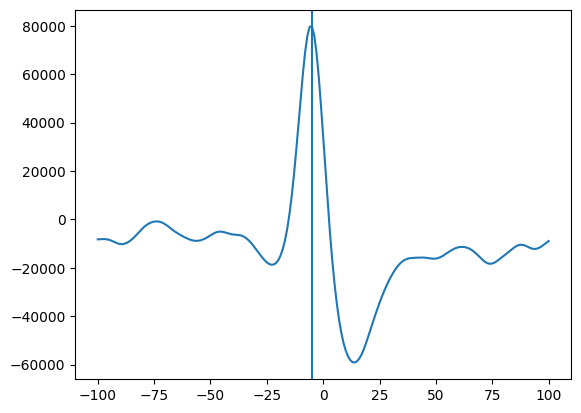

In [21]:
plt.plot(rv, CCF.sum(axis=(1,2)))
plt.axvline(-5)
plt.show()

## Cross-correlation

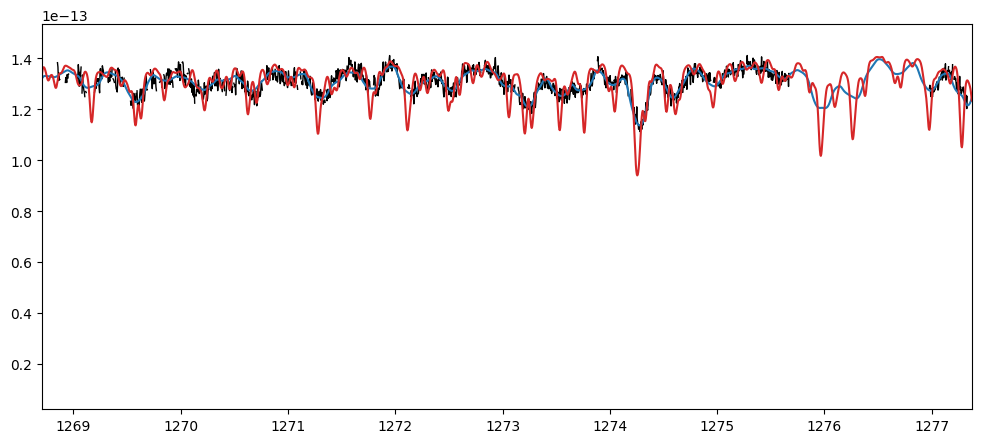

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        ax.plot(d_spec.wave[i,j], d_spec.flux[i,j], c='k', lw=1)

        ax.plot(d_spec.wave[i,j], m_spec.flux[i,j]*LogLike.f[i,j], c='C0')
        ax.plot(d_spec.wave[i,j], m_spec_hole.flux[i,j]*LogLike.f[i,j], c='C3')

ax.set(xlim=(d_spec.wave[-2,0].min(), d_spec.wave[-2,0].max()))
plt.show()

In [10]:
rv = np.arange(-50,50+1e-6,1)

CCF = np.ones((len(rv),d_spec.n_orders,d_spec.n_dets)) * np.nan

res_flux = (d_spec.flux - m_spec.flux*LogLike.f[:,:,None])

from tqdm import tqdm

for i, rv_i in enumerate(tqdm(rv)):

    params_hole['rv'] = params['rv'] + rv_i
    pRT_atm.params = params_hole

    # Compute a new model spectrum
    m_spec_hole = pRT_atm(Chem.mass_fractions, PT.temperature, params_hole, get_contr=False, get_full_spectrum=False)

    CCF[i,:,:] = np.nansum(
        res_flux * (m_spec_hole.flux*LogLike.f[:,:,None]), 
        axis=-1
        )

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


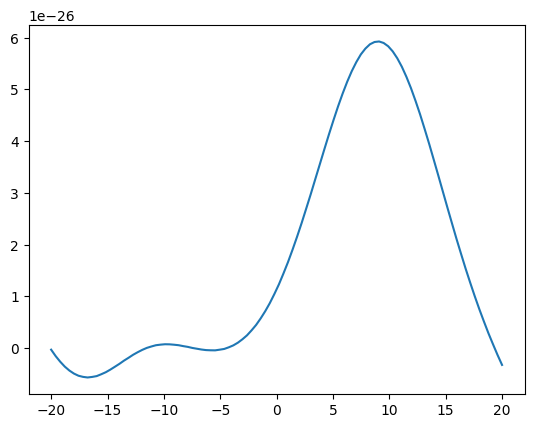

'\nfor i in range(d_spec.n_orders):\n    for j in range(d_spec.n_dets):\n        plt.plot(rv, CCF[:,i,j])\n        plt.show()\n'

In [12]:
plt.plot(rv, CCF.sum(axis=(1,2)))
plt.show()

'''
for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        plt.plot(rv, CCF[:,i,j])
        plt.show()
'''